# Assignment 2: Airline On-Time Performance Data
Airline on-time performance data from 1987 to 2012

**1987 - 2008**
| **Variable** | **Description** |
|---:|---:|
| Year | Year of flight |
| Month | Month of the flight (1 = Jan, ..., 12 = Dec) |
| DayofMonth | Day of the Month (1 to 31) |
| DayofWeek | Day of the week (1 = Monday, ..., 7 = Sunday) |
| DepTime | Actual Departure Time in 24hrs format |
| CRSDepTime | Scheduled Departure Time in 24hrs format |
| ArrTime | Actual Arrival Time in 24hrs format |
| CRSArrTime | Scheduled Arrival Time in 24hrs format |
| UniqueCarrier | Carrier Code | 
| FlightNum | Flight Number |
| TailNum | Plane's tail number |
| ActualEplapsedTime | Actual elapsed time (in minutes) |
| CRSElapsedTime | Estimated elapsed time (in minutes) |
| AirTime | Flight time (in minutes) |
| ArrDelay | Arrival Delay in minutes (ArrTime - CRSArrTime) | 
| DepDelay | Departure Delay in minutes (DepTime - CRSDepTime) |
| Origin | Origin IATA airport code |
| Dest | Destination IATA airport code|
| Distance | Distance in KM|
| TaxiIn | Wheels down and arrival at the destination airport gate (in minutes) |
| Cancelled | Was the flight cancelled? (1 = yes, 0 = no) |
| CancellationCode | Reasons for cancellation (A = carrier, B =  weather, C = NAS, D = security) |
| Diverted | 1 = yes, 0 = no |
| CarrierDelay | Delay (in minutes) caused by carrier |
| WeatherDelay | Delay (in minutes) caused by weather|
| NASDelay | National Air Security (NAS) delay |
| SecurityDelay | Delay (in minutes) caused by security |
| LateAircraftDelay | Delay (in minutes) caused by late aircraft |

**airports**
| **Variable** | **Description** |
| ---: | ---: | 
| iata | Airport code |
| airport | Airport Name  |
| city | Airport ity |
| state | Airport state |
| country | Airport country |
| lat | Airport latitude |
| long | Airport longitude | 

**carriers**
| **Variable** | **Description** |
| ---: | ---: | 
| Code | Carrier code |
| Description | Carrier name |

**plane-data**
| **Variable** | **Description** |
| ---: | ---: | 
| tailnum | Aircraft tial number |
| type | Usage type | 
| manufacturer | Manufacturer company | 
| issue_date | Date start operating |
| model | Aircraft model |
| status | Status |
| aircraft_type | Aircraft type |
| engine_type | Engine type |
| year | Manufacture year |

2008['TailNum'] = plane-data['tailnum']

2008[['Dest', 'Origin']] = airports['iata']

2008['UniqueCarrier'] = carriers['Code']

In [12]:
from pyhive import hive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# establish a connection to hive
conn = hive.Connection(host='localhost',
                       port=10000,
                       username='maria_dev')

# create a cursor object using the connection
cursor = conn.cursor()

def hive_query(query):
    cursor.execute(query)
    for result in cursor.fetchall():
        print(result)

In [5]:
for year in range(1987, 2009):
    location = f"/user/maria_dev/project2/{year}"
    table_name = f"project2.airline_{year}"
# Create external table pointing to the CSV
    cursor.execute(f"""
    CREATE EXTERNAL TABLE IF NOT EXISTS {table_name} (
        Year INT,
        Month INT,
        DayofMonth INT,
        DayOfWeek INT,
        DepTime INT,
        CRSDepTime INT,
        ArrTime INT,
        CRSArrTime INT,
        UniqueCarrier STRING,
        FlightNum INT,
        TailNum STRING,
        ActualElapsedTime INT,
        CRSElapsedTime INT,
        AirTime INT,
        ArrDelay INT,
        DepDelay INT,
        Origin STRING,
        Dest STRING,
        Distance INT,
        TaxiIn INT,
        TaxiOut INT,
        Cancelled INT,
        CancellationCode STRING,
        Diverted INT,
        CarrierDelay INT,
        WeatherDelay INT,
        NASDelay INT,
        SecurityDelay INT,
        LateAircraftDelay INT
    )
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    STORED AS TEXTFILE
    LOCATION '{location}'
    TBLPROPERTIES ("skip.header.line.count"="1")
    """)


In [ ]:
cursor.execute("""
               CREATE TABLE IF NOT EXISTS project2.airports (
                iata STRING,
                airport STRING,
                city STRING,
                state STRING,
                country STRING,
                lat FLOAT,
                long FLOAT
               )
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                STORED AS TEXTFILE
                LOCATION '/user/maria_dev/project2/airports'
                TBLPROPERTIES ("skip.header.line.count"="1")
                """)


In [ ]:
cursor.execute("""
               CREATE TABLE IF NOT EXISTS project2.carriers (
                Code STRING,
                Description STRING
               )
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                STORED AS TEXTFILE
                LOCATION '/user/maria_dev/project2/carriers'
                TBLPROPERTIES ("skip.header.line.count"="1")
""")


In [ ]:
cursor.execute("""
               CREATE TABLE IF NOT EXISTS project2.plane_data (
                tailnum STRING,
                type STRING,
                manufacturer STRING,
                issue_date STRING,
                model STRING,
                status STRING,
                serial_number STRING,
                engine_type STRING,
                year INT
               )
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                STORED AS TEXTFILE
                LOCATION '/user/maria_dev/project2/plane_data'
                TBLPROPERTIES ("skip.header.line.count"="1")
""")


<h1 style = 'font-weight:bold'> 1. Delay patterns </h1>
<h2> 1.1 What times of the day have the lowest average delays </h2>

In [ ]:
# combine all airline data from 1987 to 2008 into a single table airline_all
years = range(1987, 2009)  
union_query_parts = [f"SELECT * FROM project2.airline_{year}" for year in years]
union_all_query = " UNION ALL\n".join(union_query_parts)

cursor.execute(f"""
CREATE TABLE IF NOT EXISTS project2.airline_all
AS
{union_all_query}
""")

In [ ]:
# query data of average departure delay by time of day
query1 = """
    SELECT
        CASE
            WHEN crsdeptime BETWEEN 500 AND 1159 THEN 'Morning'
            WHEN crsdeptime BETWEEN 1200 AND 1659 THEN 'Afternoon'
            WHEN crsdeptime BETWEEN 1700 AND 2059 THEN 'Evening'
            ELSE 'Night'
        END AS time_of_day,
        AVG(depdelay) AS avg_depdelay
    FROM project2.airline_all
    WHERE depdelay IS NOT NULL
    AND crsdeptime IS NOT NULL
    GROUP BY
        CASE
            WHEN crsdeptime BETWEEN 500 AND 1159 THEN 'Morning'
            WHEN crsdeptime BETWEEN 1200 AND 1659 THEN 'Afternoon'
            WHEN crsdeptime BETWEEN 1700 AND 2059 THEN 'Evening'
            ELSE 'Night'
        END
    ORDER BY avg_depdelay
"""

df = pd.read_sql(query1, conn)
df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_5596\2051806102.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query1, conn)


,time_of_day,avg_depdelay
0,Morning,4.321774
1,Afternoon,8.847098
2,Night,10.551352
3,Evening,12.895181


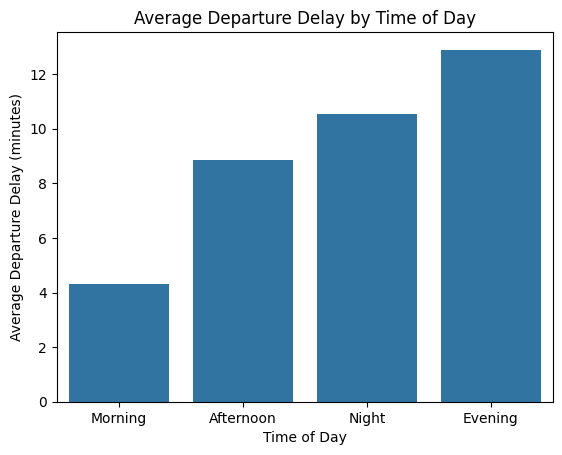

In [ ]:
# visualize the average departure delay by time of day
sns.barplot(x = 'time_of_day', y = 'avg_depdelay', data = df)
plt.title("Average Departure Delay by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Average Departure Delay (minutes)")
plt.show();

<h2> 1.2 Which days of the week show better on-time performance? </h2>

In [ ]:
query = """
    SELECT 
        dayofweek,
        COUNT(*) AS total_flights,
        SUM(CASE WHEN depdelay <= 0 THEN 1 ELSE 0 END) AS on_time_flights,
        ROUND(100.0 * SUM(CASE WHEN depdelay <= 0 THEN 1 ELSE 0 END) / COUNT(*), 2) AS on_time_percent
    FROM project2.airline_all
    WHERE depdelay IS NOT NULL AND dayofweek IS NOT NULL
    GROUP BY dayofweek
    ORDER BY on_time_percent DESC
"""

df2 = pd.read_sql(query, conn)
df2

C:\Users\user\AppData\Local\Temp\ipykernel_5596\456788989.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(query, conn)


,dayofweek,total_flights,on_time_flights,on_time_percent
0,2,17023604,10670456,62.68
1,6,15090192,9150944,60.64
2,3,17075451,10301016,60.33
3,1,17114412,10257209,59.93
4,7,16248655,9255218,56.96
5,4,17053551,9547380,55.98
6,5,17078261,9191002,53.82


Text(0.5, 1.0, 'On-Time Performance by Day of Week')

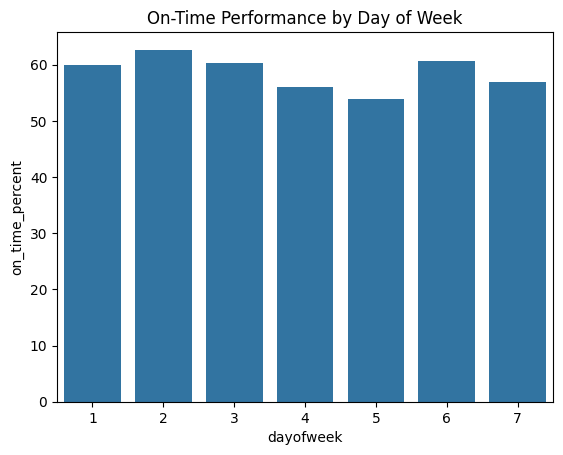

In [15]:
sns.barplot(x='dayofweek', y='on_time_percent', data=df2)
plt.title("On-Time Performance by Day of Week")

<h2> 1.3 During which months or seasons are flights most likely to be on time? </h2>

In [22]:
query3 = """
    SELECT 
        month,
        COUNT(*) AS total_flights,
        SUM(CASE WHEN depdelay <= 0 THEN 1 ELSE 0 END) AS on_time_flights,
        ROUND(100.0 * SUM(CASE WHEN depdelay <= 0 THEN 1 ELSE 0 END) / COUNT(*), 2) AS on_time_percent
    FROM project2.airline_all
    WHERE depdelay IS NOT NULL AND month IS NOT NULL
    GROUP BY month
    ORDER BY on_time_percent DESC
"""

df3 = pd.read_sql(query3, conn)
df3

C:\Users\user\AppData\Local\Temp\ipykernel_5596\1065052547.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df3 = pd.read_sql(query3, conn)


,month,total_flights,on_time_flights,on_time_percent
0,9,9179898,6071140,66.14
1,5,9603585,5970467,62.17
2,10,10071314,6259621,62.15
3,4,9956265,6134349,61.61
4,11,9573697,5746828,60.03
5,2,9182556,5278669,57.49
6,3,10235777,5866618,57.31
7,8,9877597,5635316,57.05
8,1,9950241,5669081,56.97
9,7,9788085,5465171,55.83


In [23]:
query4 = """
    SELECT 
    CASE 
        WHEN month IN (12, 1, 2) THEN 'Winter'
        WHEN month IN (3, 4, 5) THEN 'Spring'
        WHEN month IN (6, 7, 8) THEN 'Summer'
        WHEN month IN (9, 10, 11) THEN 'Fall'
    END AS season,
    COUNT(*) AS total_flights,
    SUM(CASE WHEN depdelay <= 0 THEN 1 ELSE 0 END) AS on_time_flights,
    ROUND(100.0 * SUM(CASE WHEN depdelay <= 0 THEN 1 ELSE 0 END) / COUNT(*), 2) AS on_time_percent
    FROM project2.airline_all
    WHERE depdelay IS NOT NULL AND month IS NOT NULL
    GROUP BY 
    CASE 
        WHEN month IN (12, 1, 2) THEN 'Winter'
        WHEN month IN (3, 4, 5) THEN 'Spring'
        WHEN month IN (6, 7, 8) THEN 'Summer'
        WHEN month IN (9, 10, 11) THEN 'Fall'
    END
    ORDER BY on_time_percent DESC
"""

df4 = pd.read_sql(query4, conn)
df4

C:\Users\user\AppData\Local\Temp\ipykernel_5596\1790978808.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df4 = pd.read_sql(query4, conn)


,season,total_flights,on_time_flights,on_time_percent
0,Fall,28824909,18077589,62.72
1,Spring,29795627,17971434,60.32
2,Summer,29128899,16299607,55.96
3,Winter,28934691,16024595,55.38


In [ ]:
# combine month and season data

<h1 style='font-weight:bold'> 2. Delay Factors </h1>
<h2> 2.1 Identify and rank the top 3 - 5 factors contributing to flight delays, based on the delays categories provided in the dataset </h2>

In [ ]:
query5 = """
    SELECT 
        'Carrier Delay' AS delay_type, 
        SUM(carrierdelay) AS total_delay 
    FROM project2.airline_all
    UNION ALL
    SELECT 
        'Weather Delay', 
        SUM(weatherdelay) 
    FROM project2.airline_all
    UNION ALL
    SELECT 
        'NAS Delay', 
        SUM(nasdelay) 
    FROM project2.airline_all
    UNION ALL
    SELECT 
        'Security Delay', 
        SUM(securitydelay) 
    FROM project2.airline_all
    UNION ALL
    SELECT 
        'Late Aircraft Delay', 
        SUM(lateaircraftdelay) 
    FROM project2.airline_all
    ORDER BY total_delay DESC
    LIMIT 5
"""

df5 = pd.read_sql(query5, conn)
df5

C:\Users\user\AppData\Local\Temp\ipykernel_5596\2726025457.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df5 = pd.read_sql(query5, conn)


,_u1.delay_type,_u1.total_delay
0,Late Aircraft Delay,143279932
1,NAS Delay,123638531
2,Carrier Delay,111115872
3,Weather Delay,24049544
4,Security Delay,846239


<h2> 2.2 Quantify the impact of each factor (in minutes of delay and percentage of total delays). </h2>

In [25]:
query6 = """
    WITH delay_totals AS (
    SELECT
        SUM(carrierdelay) AS carrier,
        SUM(weatherdelay) AS weather,
        SUM(nasdelay) AS nas,
        SUM(securitydelay) AS security,
        SUM(lateaircraftdelay) AS late_aircraft
    FROM project2.airline_all
    ),
    total_delay AS (
    SELECT
        (carrier + weather + nas + security + late_aircraft) AS grand_total
    FROM delay_totals
    )

    SELECT
    'Carrier Delay' AS delay_type,
    dt.carrier AS delay_minutes,
    ROUND(100.0 * dt.carrier / td.grand_total, 2) AS percentage
    FROM delay_totals dt, total_delay td

    UNION ALL

    SELECT
    'Weather Delay',
    dt.weather,
    ROUND(100.0 * dt.weather / td.grand_total, 2)
    FROM delay_totals dt, total_delay td

    UNION ALL

    SELECT
    'NAS Delay',
    dt.nas,
    ROUND(100.0 * dt.nas / td.grand_total, 2)
    FROM delay_totals dt, total_delay td

    UNION ALL

    SELECT
    'Security Delay',
    dt.security,
    ROUND(100.0 * dt.security / td.grand_total, 2)
    FROM delay_totals dt, total_delay td

    UNION ALL

    SELECT
    'Late Aircraft Delay',
    dt.late_aircraft,
    ROUND(100.0 * dt.late_aircraft / td.grand_total, 2)
    FROM delay_totals dt, total_delay td

    ORDER BY percentage DESC
"""

df6 = pd.read_sql(query6, conn)
df6


C:\Users\user\AppData\Local\Temp\ipykernel_5596\712895008.py:58: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df6 = pd.read_sql(query6, conn)


,u1.delay_type,u1.delay_minutes,u1.percentage
0,Late Aircraft Delay,143279932,35.56
1,NAS Delay,123638531,30.68
2,Carrier Delay,111115872,27.58
3,Weather Delay,24049544,5.97
4,Security Delay,846239,0.21


<h1 style='font-weight:bold'> 3. Cancellation Analysis </h1>

<h2> 3.1 Identify the primary reasons for flight cancellations as categorized in the dataset. </h2>

In [ ]:
query7 = """
    SELECT
    CASE cancellationcode
        WHEN 'A' THEN 'Carrier'
        WHEN 'B' THEN 'Weather'
        WHEN 'C' THEN 'NAS'
        WHEN 'D' THEN 'Security'
        ELSE 'Unknown'
    END AS cancellation_reason,
    COUNT(*) AS total_cancellations
    FROM project2.airline_all
    WHERE cancelled = 1 AND cancellationcode IS NOT NULL
    GROUP BY
    CASE cancellationcode
        WHEN 'A' THEN 'Carrier'
        WHEN 'B' THEN 'Weather'
        WHEN 'C' THEN 'NAS'
        WHEN 'D' THEN 'Security'
        ELSE 'Unknown'
    END
    ORDER BY total_cancellations DESC
"""

df7 = pd.read_sql(query7, conn)
df7

<h2> Determine if cancellations correlate with specific airlines, airports, or time periods. </h2>

In [ ]:
# by airline
query8 = """
    SELECT
        uniquecarrier AS airline,
        COUNT(*) AS total_flights,
        SUM(CASE WHEN cancelled = 1 THEN 1 ELSE 0 END) AS cancellations,
        ROUND(100.0 * SUM(CASE WHEN cancelled = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancel_rate
    FROM project2.airline_all
    GROUP BY uniquecarrier
    ORDER BY cancel_rate DESC
"""

df8 = pd.read_sql(query8, conn)
df8

C:\Users\user\AppData\Local\Temp\ipykernel_5596\2997301319.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df8 = pd.read_sql(query8, conn)


,airline,total_flights,cancellations,cancel_rate
0,MQ,3632062,148107,4.08
1,YV,684812,25981,3.79
2,9E,347210,12036,3.47
3,OH,1338503,43330,3.24
4,DH,693047,22176,3.20
5,EA,919785,28702,3.12
6,EV,1508980,45996,3.05
7,OO,2718878,59727,2.20
8,UA,13004338,284581,2.19
9,XE,2114556,45924,2.17


In [ ]:
# by origin airport
query9 = """
  SELECT
    origin AS airport,
    COUNT(*) AS total_flights,
    SUM(CASE WHEN cancelled = 1 THEN 1 ELSE 0 END) AS cancellations,
    ROUND(100.0 * SUM(CASE WHEN cancelled = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancel_rate
  FROM project2.airline_all
  GROUP BY origin
  ORDER BY cancel_rate DESC
"""

df9 = pd.read_sql(query9, conn)
df9

In [19]:
# by month
query10 = """
    SELECT
        month,
        COUNT(*) AS total_flights,
        SUM(CASE WHEN cancelled = 1 THEN 1 ELSE 0 END) AS cancellations,
        ROUND(100.0 * SUM(CASE WHEN cancelled = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancel_rate
    FROM project2.airline_all
    GROUP BY month
    ORDER BY cancel_rate DESC
"""

df10 = pd.read_sql(query10, conn)
df10

C:\Users\user\AppData\Local\Temp\ipykernel_5596\1841743741.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df10 = pd.read_sql(query10, conn)


,month,total_flights,cancellations,cancel_rate
0,1,10272489,322248,3.14
1,9,9435046,255148,2.70
2,2,9431225,248669,2.64
3,12,10027298,225404,2.25
4,3,10448039,212262,2.03
5,6,9618281,155064,1.61
6,7,9944011,155926,1.57
7,8,10034556,156959,1.56
8,10,10202453,131139,1.29
9,11,9694904,121207,1.25


<h1 style='font-weight:bold'> Problematic Routes </h1>

<h2> identify specific routes (origin-destination pairs), carriers, or flight numbers that show consistently poor performance </h2>

In [20]:
# by route
query11 = """
    SELECT
        origin,
        dest,
        COUNT(*) AS total_flights,
        AVG(depdelay) AS avg_depdelay,
        SUM(CASE WHEN cancelled = 1 THEN 1 ELSE 0 END) AS cancellations,
        ROUND(100.0 * SUM(CASE WHEN cancelled = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancel_rate
    FROM project2.airline_all
    WHERE depdelay IS NOT NULL OR cancelled = 1
    GROUP BY origin, dest
    HAVING COUNT(*) >= 100  -- Filter out rare routes
    ORDER BY avg_depdelay DESC, cancel_rate DESC
    LIMIT 10
"""

df11 = pd.read_sql(query11, conn)
df11

C:\Users\user\AppData\Local\Temp\ipykernel_5596\3873773230.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df11 = pd.read_sql(query11, conn)


,origin,dest,total_flights,avg_depdelay,cancellations,cancel_rate
0,MKE,MQT,128,62.169492,10,7.81
1,ACK,JFK,147,55.090909,15,10.20
2,ASE,ORD,584,48.986408,69,11.82
3,SFO,EGE,439,40.937500,7,1.59
4,ASE,SFO,162,39.661972,20,12.35
5,MQT,MKE,127,38.474576,9,7.09
6,DFW,MDT,602,31.933447,16,2.66
7,LGA,FNT,283,31.879668,42,14.84
8,EGE,MIA,381,31.762667,6,1.57
9,DAB,LGA,175,31.743902,11,6.29


In [21]:
# by flight number
query12 = """
        SELECT
        flightnum,
        COUNT(*) AS total_flights,
        AVG(depdelay) AS avg_depdelay,
        ROUND(100.0 * SUM(CASE WHEN cancelled = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancel_rate
    FROM project2.airline_all
    WHERE depdelay IS NOT NULL OR cancelled = 1
    GROUP BY flightnum
    HAVING COUNT(*) >= 100  -- Filter out uncommon flights
    ORDER BY avg_depdelay DESC, cancel_rate DESC
    LIMIT 10
"""

df12 = pd.read_sql(query12, conn)
df12

C:\Users\user\AppData\Local\Temp\ipykernel_5596\3497109198.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df12 = pd.read_sql(query12, conn)


,flightnum,total_flights,avg_depdelay,cancel_rate
0,6001,163,44.319149,13.50
1,7188,1006,40.204211,5.57
2,7474,911,33.942330,4.83
3,7426,681,33.921997,5.87
4,6007,109,33.682243,1.83
5,7256,1406,33.573733,7.40
6,7458,1023,33.527495,4.01
7,7368,933,33.508855,9.22
8,7617,545,33.091618,5.87
9,7238,1134,33.022472,5.82


<h2> Analyse the reasons these particular flights are prone to delays or cancellations. </h2>

In [ ]:
query13 = """
    CREATE TEMPORARY TABLE project2.bad_flights AS
        SELECT
        origin,
        dest,
        flightnum,
        AVG(depdelay) AS avg_depdelay,
        COUNT(*) AS total_flights
    FROM project2.airline_all
    WHERE depdelay IS NOT NULL
    GROUP BY origin, dest, flightnum
    HAVING COUNT(*) >= 100 AND avg_depdelay > 30
"""

query14 = """
    SELECT
        a.origin,
        a.dest,
        a.flightnum,
        SUM(carrierdelay) AS total_carrier_delay,
        SUM(weatherdelay) AS total_weather_delay,
        SUM(nasdelay) AS total_nas_delay,
        SUM(securitydelay) AS total_security_delay,
        SUM(lateaircraftdelay) AS total_lateaircraft_delay
    FROM project2.airline_all a
    JOIN project2.bad_flights b
        ON a.origin = b.origin AND a.dest = b.dest AND a.flightnum = b.flightnum
    GROUP BY a.origin, a.dest, a.flightnum
    ORDER BY total_carrier_delay + total_weather_delay + total_nas_delay + total_security_delay + total_lateaircraft_delay DESC;
"""

query15 = """
    SELECT
    a.origin,
    a.dest,
    a.flightnum,
    CASE cancellationcode
        WHEN 'A' THEN 'Carrier'
        WHEN 'B' THEN 'Weather'
        WHEN 'C' THEN 'NAS'
        WHEN 'D' THEN 'Security'
        ELSE 'Unknown'
    END AS cancellation_reason,
    COUNT(*) AS cancellations
    FROM project2.airline_all a
    JOIN project2.bad_flights b
        ON a.origin = b.origin AND a.dest = b.dest AND a.flightnum = b.flightnum
    WHERE a.cancelled = 1
    GROUP BY a.origin, a.dest, a.flightnum, cancellationcode
    ORDER BY cancellations DESC
"""


<h1> References </h1>
1. https://cs229.stanford.edu/proj2013/MathurNagaoNg-PredictingFlightOnTimePerformance.pdf <br>
2. https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi%3A10.7910%2FDVN%2FHG7NV7 <br>
3. https://learn.microsoft.com/en-us/previous-versions/microsoft-r/r-reference/revoscaler/airontime87to12
4. 